# Initial check for CryptoQuant data
   * tasks
       * classify tables 
       * classify data types
       * build an initial data loader
   * data structure
       * instrument_list ['btc', 'stablecoin', 'erc20', 'eth']
       * exchange_list = ['coinbase_pro', 'derivative_exchange', 'deribit', 'binance', 'all_exchange', 'spot_exchange']
       * datatype (number of tales)
           * exchange-flows (5)
           * flow-indicator (5)
           * Market Indicator (3)
           * Network Indicator (5)
           * miner-flows (3)
           * Bank Flows (0)
           * Inter Entity Flows (1)
           * Fund Data (1)
           * market data (5)
           * network data (4)

In [1]:
import pandas as pd
from croqr.common.config import LOCAL_DATA_DIR, LOCAL_FIGURE_DIR
import os
from croqr.data.cq.config import CryptoQuantData
from datetime import datetime
import matplotlib.pyplot as plt
from croqr.common.utils import timeit, save_df
import numpy as np
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

### Calcualted correlation between features and returns
   * for each feature, get the change rate of of the feature numbers
   * calcualte corr between change on features v.s. change on close price (ret)
   * try different time scale, sampling frequency, 1Min, 5Min
   * try different lag
   * rolling historical corr
 

In [2]:
@timeit
def align_feature_df(raw_feature_df, feature_list, ret_df):
    # reverse time index
    feature_df = raw_feature_df[::-1].reset_index()
    
    # get signal_time
    feature_df['signal_time'] = feature_df['datetime'].apply(lambda x: x.ceil('min'))
    
    # select revelant columns
    feature_df = feature_df[feature_list + ['signal_time']].set_index('signal_time')
    
    # drop duplicated index
    feature_df = feature_df[~feature_df.index.duplicated(keep='first')]
    
    # align to ret dataframe
    aligned_feature_df = feature_df.reindex(index=ret_df.index).ffill()
    
    return aligned_feature_df

In [3]:
@timeit
def get_feature_df_corr_with_ret(df_features, feature_table_name, ret_df, look_back_window = 60*24):
    feature_list = df_features.columns
    df_features_chg = df_features.pct_change().ffill(0)
    n = len(feature_list)
    fig=plt.figure(num=1,figsize=(6,4*n))
    
    for i, feature in enumerate(feature_list):
        ax1=fig.add_subplot(n, 1, i+1)

        f_chg = df_features_chg[feature]
        f_chg.rolling(look_back_window, min_periods=look_back_window//2).corr(ret_df).rolling(look_back_window*100, min_periods=look_back_window//2).mean().plot(ax=ax1)
        f_chg.shift(10).rolling(look_back_window, min_periods=look_back_window//2).corr(ret_df).rolling(look_back_window*100, min_periods=look_back_window//2).mean().plot(ax=ax1)
        f_chg.shift(20).rolling(look_back_window, min_periods=look_back_window//2).corr(ret_df).rolling(look_back_window*100, min_periods=look_back_window//2).mean().plot(ax=ax1)
        f_chg.shift(30).rolling(look_back_window, min_periods=look_back_window//2).corr(ret_df).rolling(look_back_window*100, min_periods=look_back_window//2).mean().plot(ax=ax1)
        ax1.legend(['lag=0', 'lag=10','lag=20','lag=30'])
        ax1.title.set_text(feature)
        ax1.get_xaxis().set_visible(False)
        ax1.grid(True, axis='x')
    fig.show()
    fig.savefig(os.path.join(LOCAL_FIGURE_DIR, '{}.png'.format(feature_table_name)))    

### plot correlation

In [4]:
data_dict = pd.read_pickle(os.path.join(LOCAL_DATA_DIR, 'cq2.pkl'))

In [5]:
all_feature_list = list(data_dict.keys())

In [6]:
all_feature_list.remove('btc-all_exchange-market-data-price-usd')

In [7]:
all_feature_list

['btc-all_exchange-market-data-open-interest',
 'btc-all_exchange-market-data-funding-rates',
 'btc-all_exchange-market-data-taker-buy-sell-stats',
 'btc-all_exchange-market-data-liquidations',
 'btc-all_exchange-exchange-flows-netflow',
 'btc-all_exchange-exchange-flows-reserve',
 'btc-all_exchange-exchange-flows-inflow',
 'btc-all_exchange-exchange-flows-outflow',
 'btc-all_exchange-miner-flows-inflow',
 'btc-all_exchange-miner-flows-outflow',
 'btc-all_exchange-miner-flows-netflow',
 'btc-all_exchange-inter-entity-flows-miner-to-exchange',
 'btc-all_exchange-fund-data-market-premium',
 'btc-all_exchange-network-data-fees-transaction',
 'btc-all_exchange-network-data-difficulty',
 'btc-all_exchange-network-data-addresses-count',
 'btc-all_exchange-network-data-supply',
 'btc-all_exchange-flow-indicator-mpi',
 'btc-all_exchange-flow-indicator-exchange-shutdown-index',
 'btc-all_exchange-flow-indicator-exchange-whale-ratio',
 'btc-all_exchange-flow-indicator-fund-flow-ratio',
 'btc-all

In [9]:
btc_close = data_dict['btc-all_exchange-market-data-price-usd']['price_usd_close'][::-1]
ret_df = btc_close.pct_change()

In [10]:
df0 = data_dict['btc-all_exchange-market-data-price-usd']
save_df(df0, 'df0')

saved df to C:\Users\Wang\Documents\GitHub\data\df0.pickle


In [14]:
feature_exlusion_list = ['blockheight', 'datetime']
feature_list = [x for x in feature_table.columns if x not in feature_exlusion_list]
display(feature_list)

['inflow_total', 'inflow_top10', 'inflow_mean']

In [15]:
aligned_feature_df = align_feature_df(feature_table, feature_list, ret_df)

'align_feature_df'  32.87 sec


<ipython-input-24-fd07749d0050>:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


'get_feature_df_corr_with_ret'  84.30 sec


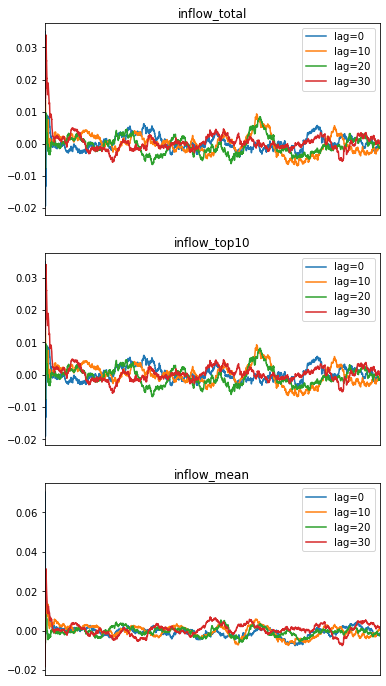

In [25]:
get_feature_df_corr_with_ret(aligned_feature_df, feature_table_name, ret_df)

In [18]:
log_file_name = 'cq_corr_{}.log'.format(datetime.now().strftime('%Y%m%d%H%M%S'))

In [3]:
df_features_chg = pd.DataFrame(np.random.randint(0,100,size=(100, 4)), columns=list('ABCD')).pct_change()
df_features_chg.head()

,A,B,C,D
0,NaN,NaN,NaN,NaN
1,-0.540984,-0.176471,7.833333,-0.092308
2,1.571429,0.071429,0.415094,-0.389831
3,-0.847222,-0.633333,-0.013333,1.333333
4,4.181818,7.363636,-0.540541,-0.345238


<ipython-input-13-eb465ebf3cc0>:20: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax1.hlines(y=0, xmin=f_chg.index.min(), xmax=f_chg.index.max(), linewidth=2, color='r', label=['0'], Linestyles='dotted')
<ipython-input-13-eb465ebf3cc0>:20: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax1.hlines(y=0, xmin=f_chg.index.min(), xmax=f_chg.index.max(), linewidth=2, color='r', label=['0'], Linestyles='dotted')
<ipython-input-13-eb465ebf3cc0>:20: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax1.hlines(y=0, xmin=f_chg.index.min(), xmax=f_chg.index.max(), linewidth=2, color='r', label=['0'], Linestyles='dotted')
<ipython-input-13-eb465ebf3cc0>:20: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 a

<Figure size 432x288 with 0 Axes>

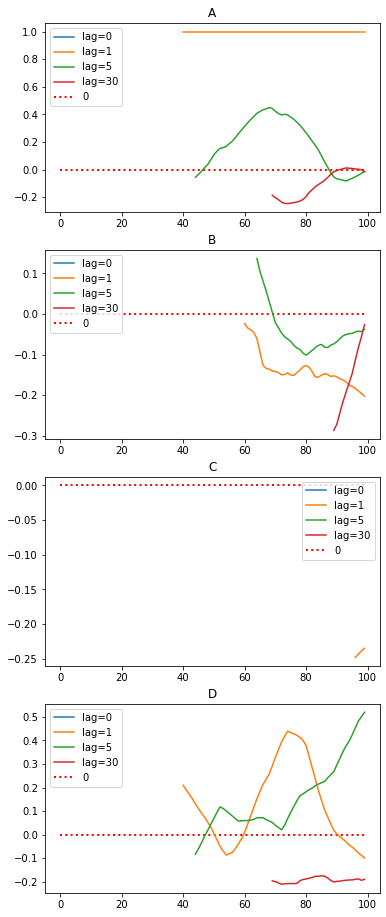

In [13]:
n=4
ret_df = df_features_chg.shift(1)['A']
look_back_window = 20
feature_list = ['A','B','C','D',]
plt.tight_layout(pad=0.5, w_pad=2.5, h_pad=2.0)
fig = plt.figure(figsize=(6, 4 * n))

for i, feature in enumerate(feature_list):
    ax1 = fig.add_subplot(n, 1, i + 1)
    ax1.grid(True, axis='x')
    f_chg = df_features_chg[feature]
    f_chg.rolling(look_back_window).corr(ret_df).rolling(look_back_window * 100).mean().plot(
        ax=ax1)
    f_chg.shift(1).rolling(look_back_window).corr(ret_df).rolling(
        look_back_window ).mean().plot(ax=ax1)
    f_chg.shift(5).rolling(look_back_window).corr(ret_df).rolling(
        look_back_window ).mean().plot(ax=ax1)
    f_chg.shift(30).rolling(look_back_window).corr(ret_df).rolling(
        look_back_window).mean().plot(ax=ax1)
    ax1.hlines(y=0, xmin=f_chg.index.min(), xmax=f_chg.index.max(), linewidth=2, color='r', label=['0'], Linestyles='dotted')
    ax1.legend(['lag=0', 'lag=1', 'lag=5', 'lag=30', '0'])
    ax1.title.set_text(feature)
    #ax1.get_xaxis().set_visible(False)

In [4]:
existing_files = [x.split('.')[0] for x in os.listdir(LOCAL_FIGURE_DIR)]

In [ ]:
btc_close.iplot()

In [11]:
ret_df

datetime
2016-06-14 03:05:00         NaN
2016-06-14 03:06:00    0.000014
2016-06-14 03:07:00   -0.000050
2016-06-14 03:08:00    0.000007
2016-06-14 03:09:00    0.000000
                         ...   
2021-05-24 15:55:00    0.001976
2021-05-24 15:56:00    0.001909
2021-05-24 15:57:00   -0.001723
2021-05-24 15:58:00    0.001823
2021-05-24 15:59:00   -0.001400
Name: price_usd_close, Length: 2599975, dtype: float64

In [16]:
ret_df.addbb??

Object `ret_df.addbb` not found.


In [1]:
from croqr.common.utils import addbb

In [20]:
df1 = ret_df.to_frame()

In [24]:
df1.pipe(addbb(df1, lags=50, methodma='ewm', methodstd='ewm', nstdh=2, nstdl=2))

AttributeError: 'Series' object has no attribute 'addma'

In [ ]:
addbb(df1, lags=50, methodma='ewm', methodstd='ewm', nstdh=2, nstdl=2).plot()

In [30]:
df1['fff'] = ret_df

In [33]:
def triangle(self,nans=True):
    n=len(self)
    self=self.mask(np.arange(n)[:,None] > np.arange(n),np.nan if nans else '' )
    return self

In [38]:
df2 = df1.head()

In [39]:
df2

,price_usd_close,fff
datetime,,
2016-06-14 03:05:00,NaN,NaN
2016-06-14 03:06:00,0.000014,0.000014
2016-06-14 03:07:00,-0.000050,-0.000050
2016-06-14 03:08:00,0.000007,0.000007
2016-06-14 03:09:00,0.000000,0.000000


In [36]:
triangle(df1.head())

In [40]:
n=len(df2)

In [41]:
np.arange(n)[:,None] > np.arange(n)

array([[False, False, False, False, False],
       [ True, False, False, False, False],
       [ True,  True, False, False, False],
       [ True,  True,  True, False, False],
       [ True,  True,  True,  True, False]])